In [50]:
%%capture
!pip install kagglehub statsforecast neuralforecast utilsforecast

In [51]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import kagglehub

import os

os.environ['NIXTLA_ID_AS_COL'] = '1'
plt.rcParams['axes.grid'] = True

In [52]:
from pandas.tseries.holiday import USFederalHolidayCalendar

from statsforecast import StatsForecast

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS, TiDE, PatchTST

from utilsforecast.losses import mae, rmse, smape
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series

In [53]:
path = kagglehub.dataset_download("robikscube/hourly-energy-consumption")

dataset = "COMED_hourly.csv"

df = pd.read_csv(f'{path}/{dataset}')
df.info()

Using Colab cache for faster access to the 'hourly-energy-consumption' dataset.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66497 entries, 0 to 66496
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Datetime  66497 non-null  object 
 1   COMED_MW  66497 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


In [54]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.sort_values('Datetime').reset_index(drop=True)

df.head(10)

,Datetime,COMED_MW
0,2011-01-01 01:00:00,9631.0
1,2011-01-01 02:00:00,9273.0
2,2011-01-01 03:00:00,9011.0
3,2011-01-01 04:00:00,8741.0
4,2011-01-01 05:00:00,8694.0
5,2011-01-01 06:00:00,8711.0
6,2011-01-01 07:00:00,8943.0
7,2011-01-01 08:00:00,9222.0
8,2011-01-01 09:00:00,9430.0
9,2011-01-01 10:00:00,9670.0


In [55]:
df['ds'] = pd.to_datetime(df['Datetime'])
df = df.rename(columns={'COMED_MW': 'y'})
df['unique_id'] = 'comed_hourly'
df = df[['unique_id', 'ds', 'y']]

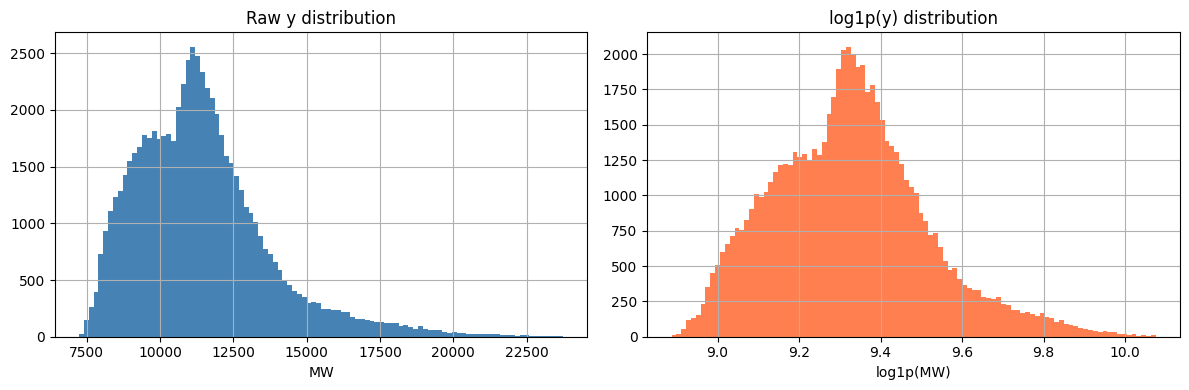

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(df['y'], bins=100, color='steelblue', edgecolor='none')
axes[0].set_title('Raw y distribution')
axes[0].set_xlabel('MW')

axes[1].hist(np.log1p(df['y']), bins=100, color='coral', edgecolor='none')
axes[1].set_title('log1p(y) distribution')
axes[1].set_xlabel('log1p(MW)')

plt.tight_layout()
plt.show()

log1p unnecessary, TemporalNorm + MAE loss handles it

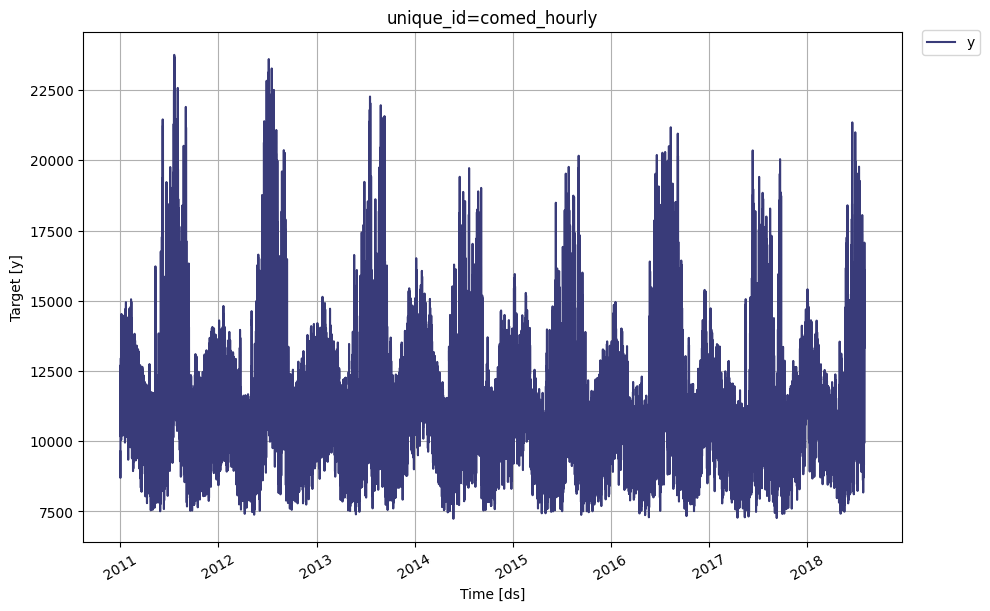

In [57]:
f = StatsForecast.plot(df)
f.set_figwidth(9)
f.set_figheight(6)
f

In [58]:
# drop nan-values from first shifts
df_clean = df.dropna().reset_index(drop=True)

test_size = 24 * 14
train_ml = df_clean.iloc[:-test_size]
test_ml  = df_clean.iloc[-test_size:]

In [59]:
forecast_horizon = 336
input_size       = 336 * 2  # 4 weeks lookback

futr_exog_cols = ['hour', 'dayofweek', 'month', 'is_holiday']

In [60]:
# calendar features
def build_nf_futr_exog(df):
    df = df.copy()
    cal         = USFederalHolidayCalendar()
    us_holidays = cal.holidays(start=df['ds'].min(), end=df['ds'].max())
    df['hour']       = df['ds'].dt.hour
    df['dayofweek']  = df['ds'].dt.dayofweek
    df['month']      = df['ds'].dt.month
    df['is_holiday'] = df['ds'].dt.normalize().isin(us_holidays).astype(int)
    return df

In [61]:
# NHITS, TiDE, PatchTST
def get_nf_models(max_steps):
    return [
        NHITS(
            h=forecast_horizon,
            input_size=input_size,
            max_steps=max_steps,
            futr_exog_list=futr_exog_cols,
            accelerator='auto',
        ),
        TiDE(
            h=forecast_horizon,
            input_size=input_size,
            max_steps=max_steps,
            futr_exog_list=futr_exog_cols,
            accelerator='auto',
        ),
        PatchTST(
            h=forecast_horizon,
            input_size=input_size,
            max_steps=max_steps,
            accelerator='auto',
        ),
    ]

In [62]:
train_nf = build_nf_futr_exog(train_ml[['unique_id', 'ds', 'y']])

In [63]:
# train + test
full_nf  = build_nf_futr_exog(
    pd.concat([
        train_ml[['unique_id', 'ds', 'y']],
        test_ml[['unique_id', 'ds', 'y']]
    ]).reset_index(drop=True)
)

In [64]:
test_futr = build_nf_futr_exog(
    test_ml[['unique_id', 'ds']].copy()
)[['unique_id', 'ds'] + futr_exog_cols]

In [65]:
nf_cv = NeuralForecast(models=get_nf_models(max_steps=1500), freq='h')

cv_nf = nf_cv.cross_validation(
    df=train_nf,
    n_windows=5,
    step_size=forecast_horizon,
    val_size=forecast_horizon,
)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.12/dist-packages/torch/nn/init.py:566: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  8.5 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 8.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.5 M                                                                                                
Total estimated model params size (MB): 34                                                                         
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                 ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss                 │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train         │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler               │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ hist_exog_projection │ MLPResidual   │  2.6 K │ train │     0 │
│ 4 │ futr_exog_projection │ MLPResidual   │  4.6 K │ train │     0 │
│ 5 │ dense_encoder        │ Sequential    │  5.1 M │ train │     0 │
│ 6 │ dense_decoder        │ Sequential    │ 11.3 M │ train │     0 │
│ 7 │ temporal_decoder     │ MLPResidual   │  4.9 K │ train │     0 │
│ 8 │ global_skip          │ Linear        │  226 K │ train │     0 │
└───┴──────────────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 16.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 16.6 M                                                                                               
Total estimated model params size (MB): 66                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  4.0 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.0 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.0 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

In [66]:
eval_nf_cv = evaluate(
    cv_nf,
    metrics=[mae, rmse],
    models=['NHITS', 'TiDE', 'PatchTST']
)

eval_nf_cv

,unique_id,cutoff,metric,NHITS,TiDE,PatchTST
0,comed_hourly,2018-05-11,mae,615.992632,519.404465,723.021012
1,comed_hourly,2018-05-25,mae,1578.825017,1851.918136,1642.062962
2,comed_hourly,2018-06-08,mae,2503.367984,1865.938947,1528.534110
3,comed_hourly,2018-06-22,mae,2474.829122,2205.163962,1487.440665
4,comed_hourly,2018-07-06,mae,2768.780951,1398.849973,1228.281913
5,comed_hourly,2018-05-11,rmse,741.662971,762.926810,873.775351
6,comed_hourly,2018-05-25,rmse,1999.142086,2486.055063,2059.751052
7,comed_hourly,2018-06-08,rmse,3468.102736,2668.441889,2264.660622
8,comed_hourly,2018-06-22,rmse,2974.770432,2971.606949,2113.340706
9,comed_hourly,2018-07-06,rmse,3566.368273,1788.852504,1550.560848


In [67]:
eval_nf_cv.drop(columns=['unique_id', 'cutoff']).groupby('metric').mean()

,NHITS,TiDE,PatchTST
metric,,,
mae,1988.359141,1568.255097,1321.868132
rmse,2550.009300,2135.576643,1772.417716


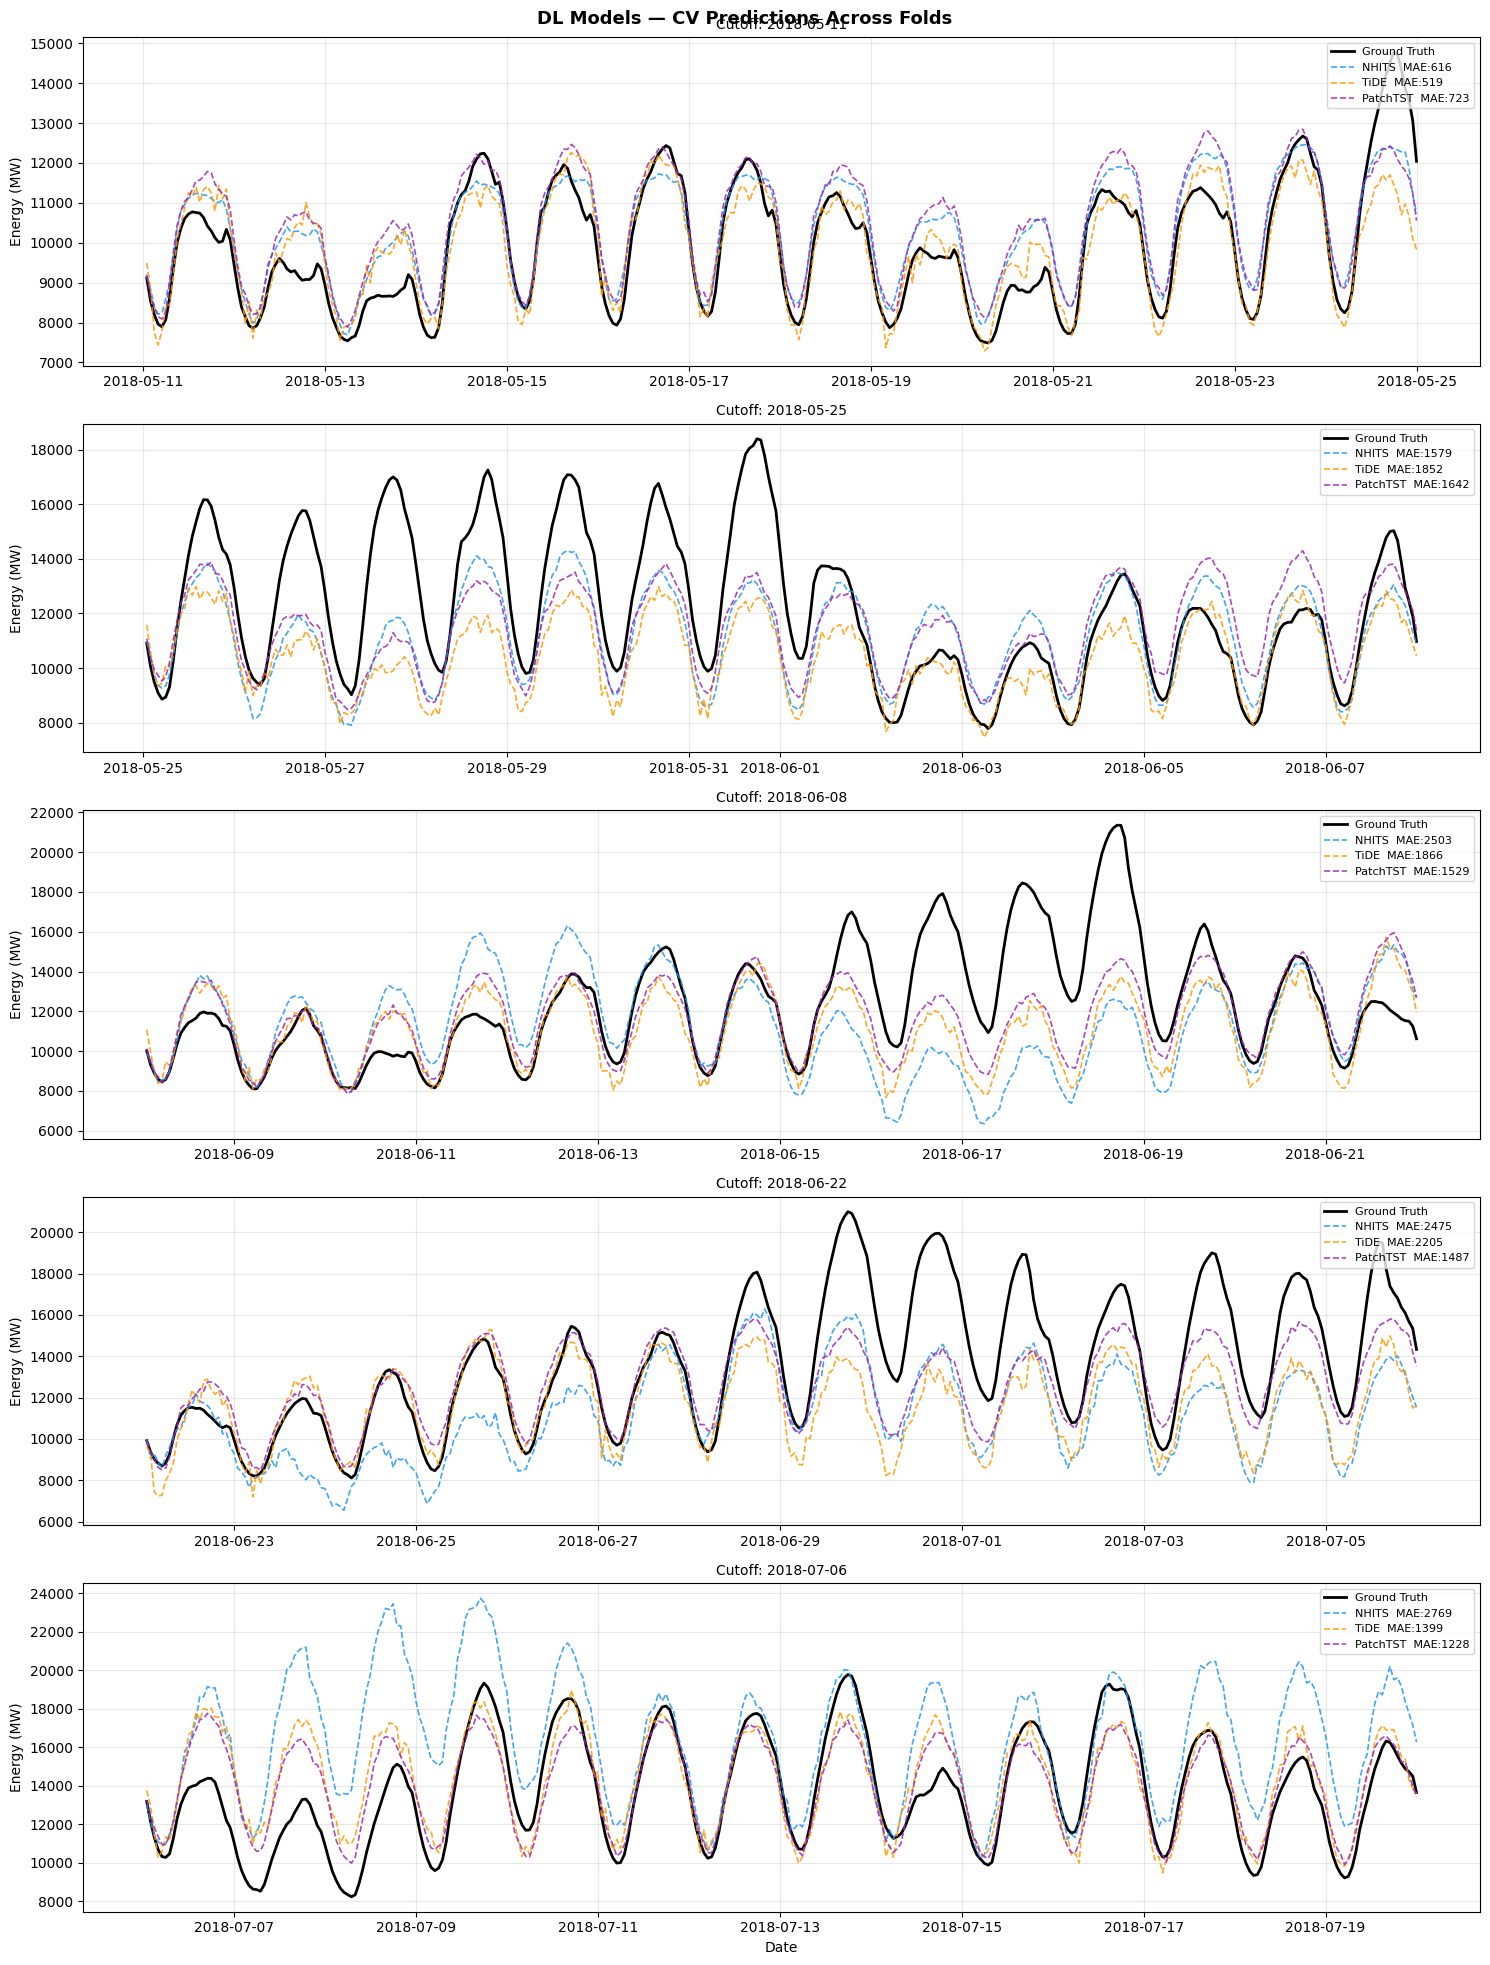

In [68]:
cutoffs = cv_nf['cutoff'].unique()
colors  = {'NHITS': '#2196F3', 'TiDE': '#FF9800', 'PatchTST': '#9C27B0'}

fig, axes = plt.subplots(len(cutoffs), 1, figsize=(15, 4 * len(cutoffs)), sharex=False)

for ax, cutoff in zip(axes, cutoffs):
    fold = cv_nf[cv_nf['cutoff'] == cutoff]

    ax.plot(fold['ds'], fold['y'],
            color='black', linewidth=2, label='Ground Truth')

    for model in ['NHITS', 'TiDE', 'PatchTST']:
        mae_val = fold[model].sub(fold['y']).abs().mean()
        ax.plot(fold['ds'], fold[model],
                color=colors[model], linewidth=1.2,
                linestyle='--', alpha=0.85,
                label=f'{model}  MAE:{mae_val:.0f}')

    ax.set_title(f'Cutoff: {str(cutoff)[:10]}', fontsize=10)
    ax.set_ylabel('Energy (MW)')
    ax.legend(loc='upper right', fontsize=8)
    ax.grid(True, alpha=0.3)

axes[-1].set_xlabel('Date')
fig.suptitle('DL Models — CV Predictions Across Folds', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

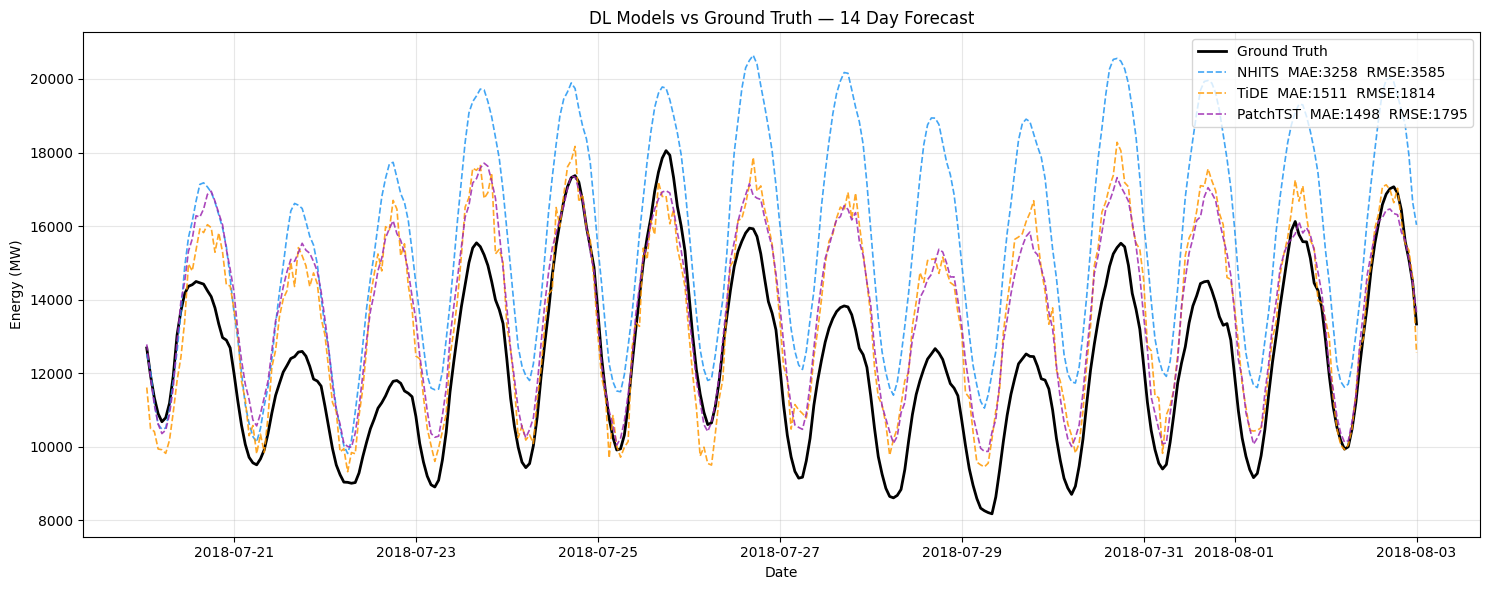

In [69]:
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(eval_df_nf['ds'], eval_df_nf['y'],
        color='black', linewidth=2, label='Ground Truth')

for model, color in colors.items():
    mae_val  = final_eval_nf[final_eval_nf['metric'] == 'mae'][model].values[0]
    rmse_val = final_eval_nf[final_eval_nf['metric'] == 'rmse'][model].values[0]
    ax.plot(eval_df_nf['ds'], eval_df_nf[model],
            color=color, linewidth=1.2, linestyle='--', alpha=0.85,
            label=f'{model}  MAE:{mae_val:.0f}  RMSE:{rmse_val:.0f}')

ax.set_title('DL Models vs Ground Truth — 14 Day Forecast', fontsize=12)
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#Inference

In [70]:
nf_final = NeuralForecast(models=get_nf_models(max_steps=1500), freq='h')
nf_final.fit(full_nf, val_size=forecast_horizon)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1
/usr/local/lib/python3.12/dist-packages/torch/nn/init.py:566: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ blocks       │ ModuleList    │  8.5 M │ train │     0 │
└───┴──────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 8.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 8.5 M                                                                                                
Total estimated model params size (MB): 34                                                                         
Modules in train mode: 34                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name                 ┃ Type          ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss                 │ MAE           │      0 │ train │     0 │
│ 1 │ padder_train         │ ConstantPad1d │      0 │ train │     0 │
│ 2 │ scaler               │ TemporalNorm  │      0 │ train │     0 │
│ 3 │ hist_exog_projection │ MLPResidual   │  2.6 K │ train │     0 │
│ 4 │ futr_exog_projection │ MLPResidual   │  4.6 K │ train │     0 │
│ 5 │ dense_encoder        │ Sequential    │  5.1 M │ train │     0 │
│ 6 │ dense_decoder        │ Sequential    │ 11.3 M │ train │     0 │
│ 7 │ temporal_decoder     │ MLPResidual   │  4.9 K │ train │     0 │
│ 8 │ global_skip          │ Linear        │  226 K │ train │     0 │
└───┴──────────────────────┴───────────────┴────────┴───────┴───────┘

Trainable params: 16.6 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 16.6 M                                                                                               
Total estimated model params size (MB): 66                                                                         
Modules in train mode: 36                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1500` reached.


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name         ┃ Type              ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ loss         │ MAE               │      0 │ train │     0 │
│ 1 │ padder_train │ ConstantPad1d     │      0 │ train │     0 │
│ 2 │ scaler       │ TemporalNorm      │      0 │ train │     0 │
│ 3 │ model        │ PatchTST_backbone │  4.0 M │ train │     0 │
└───┴──────────────┴───────────────────┴────────┴───────┴───────┘

Trainable params: 4.0 M                                                                                            
Non-trainable params: 3                                                                                            
Total params: 4.0 M                                                                                                
Total estimated model params size (MB): 16                                                                         
Modules in train mode: 90                                                                                          
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1500` reached.


In [71]:
# build future timestamps
last_ds     = full_nf['ds'].max()
future_ds   = pd.date_range(start=last_ds + pd.Timedelta(hours=1), periods=336, freq='h')
future_df   = pd.DataFrame({'unique_id': 'comed_hourly', 'ds': future_ds})
future_exog = build_nf_futr_exog(future_df)[['unique_id', 'ds'] + futr_exog_cols]

future_preds_nf = nf_final.predict(futr_df=future_exog)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

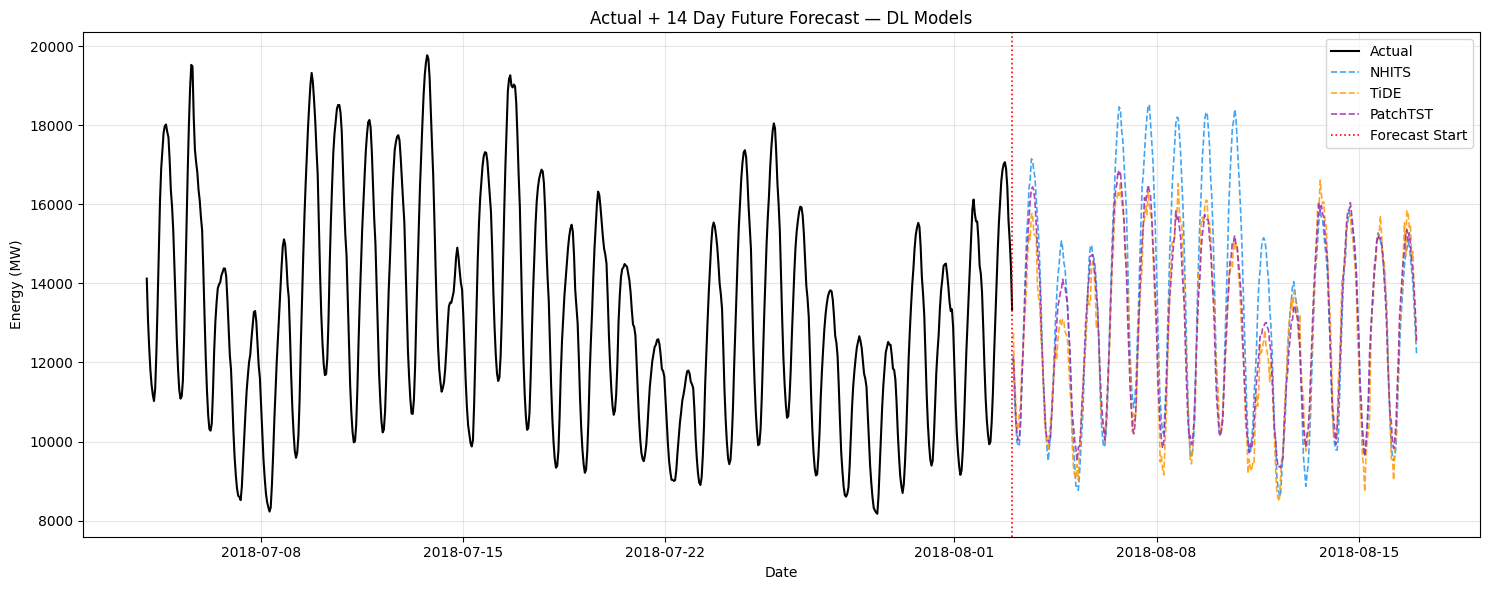

In [72]:
fig, ax = plt.subplots(figsize=(15, 6))

context = full_nf.iloc[-24*30:]  # last 30 days as context
ax.plot(context['ds'], context['y'],
        color='black', linewidth=1.5, label='Actual')

for model, color in colors.items():
    ax.plot(future_preds_nf['ds'], future_preds_nf[model],
            color=color, linewidth=1.2, linestyle='--', alpha=0.85,
            label=model)

ax.axvline(x=last_ds, color='red', linestyle=':', linewidth=1.2, label='Forecast Start')
ax.set_title('Actual + 14 Day Future Forecast — DL Models')
ax.set_xlabel('Date')
ax.set_ylabel('Energy (MW)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()